# A simple trading signal on selected S&P500 constituents using SMA
Helen Deng yiman@stanford.edu

#### In this notebook, I 
1. Fetch S&P500 stock prices from yfinance into a pandas dataframe
2. Plot the prices with the 50 day simple moving average (SMA). 
3. Calculate the momentum, which is defined as 
$$Momentum = (SMA_{today} - SMA_{yesterday}) \cdot (N+1)$$
i.e., the change in an N-day simple moving average (SMA) between yesterday and today, with a scale factor $N+1$.\
Note: With the following strategy, we can ignore the $N+1$ factor.
    
4. Generate signal to buy/sell for each trading day with the following strategy\
   For each selected stock
      - If the momentum indicator changes sign from $-$ to $+$, it corresponds to a valley in the SMA, which can be interpreted as a buy signal.
      - If the momentum indicator changes sig from $+$ to $-$, it corresponds to a peak in the SMA, which can be interpreted as a sell signal.
    - Hold the position until the buy signal changes into a sell signal, or vice versa.
5. Run it through a backtest
6. Present its PnL and other relevant risk/reward metrics

In [2]:
import os
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [3]:
# fetch S&P500 constituents using requests
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url, verify=False)
sp500 = pd.read_html(response.content)[0]
tickers = sp500.Symbol.tolist()

# define time period
start_date = "2022-01-01"
end_date = "2022-12-31"

sp500.dropna(inplace=True)
sp500.head()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'en.wikipedia.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [7]:
# fetch data for each ticker
stock_list = {i for i in sp500.head(10)["Symbol"]}
df_data = yf.download(stock_list, start=start_date, end=end_date)

[*********************100%***********************]  10 of 10 completed


In [8]:
df_data.head()

Adj Close                                                  \
                   AAP        ABBV         ABT         ACN        ADBE   
Date                                                                     
2022-01-03  228.551392  129.114441  136.128998  400.092896  564.369995   
2022-01-04  228.812012  128.866531  132.927490  397.233734  554.000000   
2022-01-05  228.232864  129.543472  132.330246  390.238190  514.429993   
2022-01-06  233.252151  128.933273  132.310654  371.393433  514.119995   
2022-01-07  229.815872  128.599579  132.721878  364.270142  510.700012   

                                                                     ...  \
                  ADM         ADP        AOS       ATVI         MMM  ...   
Date                                                                 ...   
2022-01-03  66.262703  238.103592  81.622803  67.021614  168.282120  ...   
2022-01-04  67.492508  239.215988  82.980415  66.802917  170.639587  ...   
2022-01-05  66.965454  237.176575  81.593506  65.898293  169.938995  ...   
2022-01-06  67.560814  235.546997  82.140450  63.442890  168.528244  ...   
2022-01-07  68.136673  233.058716  81.212593  63.661591  170.374496  ...   

            Volume                                                        \
               AAP     ABBV      ABT      ACN     ADBE      ADM      ADP   
Date                                                                       
2022-01-03  899800  6839800  6688100  2129900  2862700  2134200  1397000   
2022-01-04  736900  6298300  8241200  2516300  4344800  2898800  2124400   
2022-01-05  711700  7724900  5948200  2471400  7394800  2665400  2181200   
2022-01-06  602500  4667000  5710200  4386600  3913600  1920000  1946500   
2022-01-07  553600  8630300  4367500  3469000  3605400  2029200  1462000   

                                        
                AOS      ATVI      MMM  
Date                                    
2022-01-03   840000  13208100  1930700  
2022-01-04  2043200   9464000  2522200  
2022-01-05  1071800  14988200  2952400  
2022-01-06   939100  15071100  2505400  
2022-01-07  1299900  21467900  2800200  

[5 rows x 60 columns]

In [9]:
prices = {}
sma = {}
momentum_period = 30 # Define momentum period

for stock in stock_list:
    prices[stock] = df_data["Close"][stock]
    sma[stock] = df_data["Close"][stock].rolling(momentum_period).mean()

# create a DataFrame of prices
df_prices = pd.DataFrame(prices)
df_sma = pd.DataFrame(sma)
df_sma.dropna(inplace=True)

In [10]:
df_prices.head() # closing prices

,ABT,ADBE,ACN,AOS,ADP,ADM,MMM,ABBV,AAP,ATVI
Date,,,,,,,,,,
2022-01-03,139.039993,564.369995,407.209991,83.570000,244.009995,67.889999,177.740005,135.419998,236.779999,67.419998
2022-01-04,135.770004,554.000000,404.299988,84.959999,245.149994,69.150002,180.229996,135.160004,237.050003,67.199997
2022-01-05,135.160004,514.429993,397.179993,83.540001,243.059998,68.610001,179.490005,135.869995,236.449997,66.290001
2022-01-06,135.139999,514.119995,378.000000,84.099998,241.389999,69.220001,178.000000,135.229996,241.649994,63.820000
2022-01-07,135.559998,510.700012,370.750000,83.150002,238.839996,69.809998,179.949997,134.880005,238.089996,64.040001


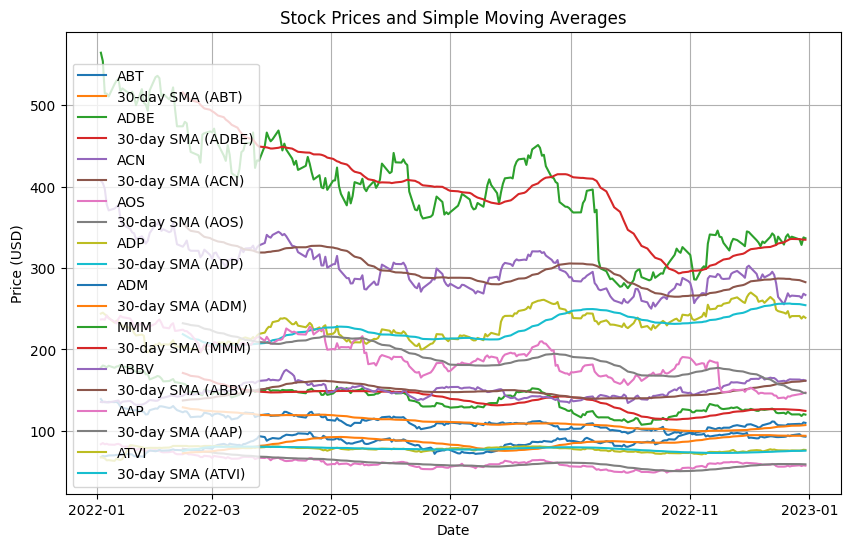

In [11]:
# Define plot size
plt.figure(figsize=(10, 6))

# Plot each stock price and SMA
for stock in stock_list:
    plt.plot(df_prices[stock], label=stock)
    plt.plot(df_sma[stock], label=f"{momentum_period}-day SMA ({stock})")

# Add title, labels, legend, gridlines
plt.title("Stock Prices and Simple Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()

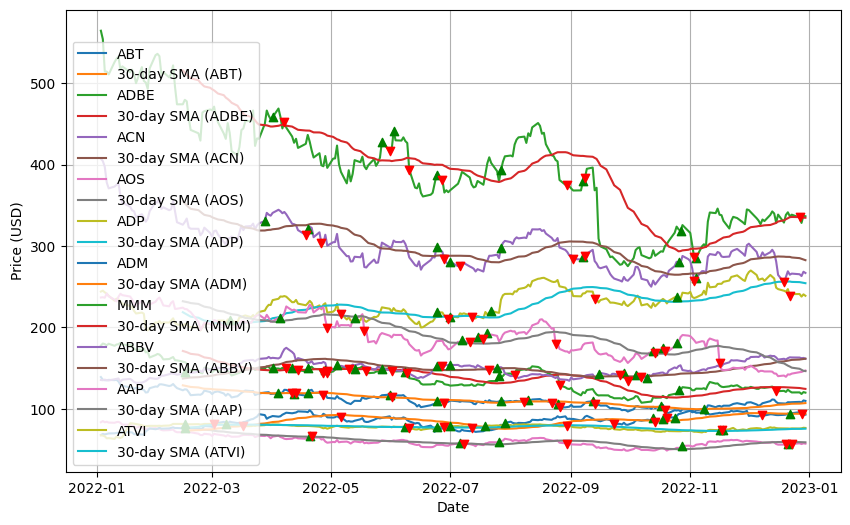

In [12]:
df_signals = pd.DataFrame(index=df_sma.index)
df_position = pd.DataFrame(index=df_sma.index)
plt.figure(figsize=(10, 6))

for stock in stock_list:
    df_signals[stock] = 0.0
    sma_diff = df_sma[stock].diff() # Calculate the difference between SMA values
    df_signals[stock] = np.where(sma_diff > 0, 1.0, 0.0) # signal
    df_position[stock] = df_signals[stock].diff() # position
    
    # When position is 1, signal has changed from 0 to 1, momentum has changed from - to +, buy signal
    # When position is -1, signal has changed from 1 to 0, momentum has changed from + to -, sell signal
    
    plt.plot(df_prices[stock], label=stock)
    plt.plot(df_sma[stock], label=f"{momentum_period}-day SMA ({stock})")
    # Plot positions
    buy = df_position[df_position[stock] == 1]
    sell = df_position[df_position[stock] == -1]
    plt.scatter(buy.index, df_prices.loc[buy.index, stock], marker="^", color="g", zorder=3)
    plt.scatter(sell.index, df_prices.loc[sell.index, stock], marker="v", color="r", zorder=3)
    plt.legend()


plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid()
plt.show()
# green triangle up indicates buy position, and red triangle down indicates sell position

In [13]:
df_position_returns = pd.DataFrame(index=df_sma.index)

for stock in stock_list:
    returns = df_prices[stock].pct_change()
    df_position_returns[stock] = df_position[stock].shift(1) * returns

portfolio_returns = df_position_returns.sum(axis=1)
cumulative_returns = (1 + portfolio_returns).cumprod() - 1

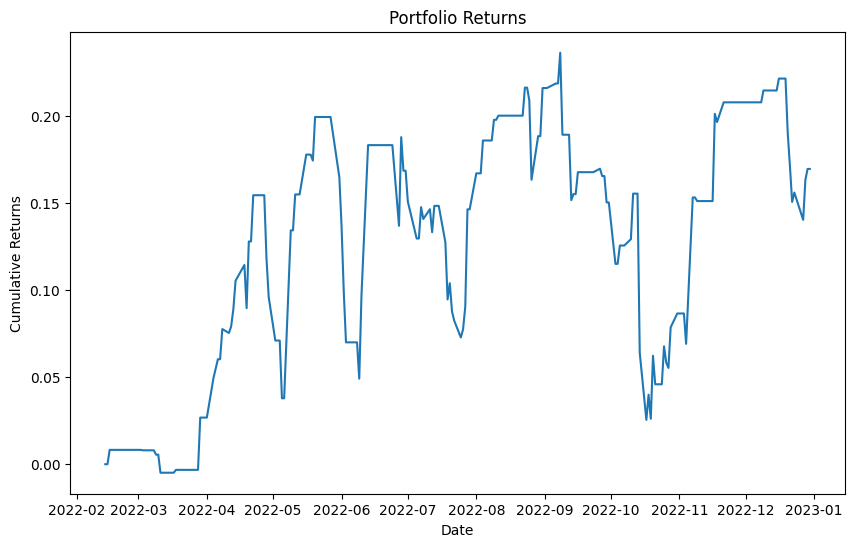

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns)
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Portfolio Returns")
plt.show()

In [15]:
# Evalutaion
pnl = cumulative_returns.iloc[-1]
annualized_volatility = portfolio_returns.std() * np.sqrt(252)
print("The stock list ", stock_list, " has PnL: ", pnl, " and annualized volatility of: ", annualized_volatility)

The stock list  {'ABT', 'ADBE', 'ACN', 'AOS', 'ADP', 'ADM', 'MMM', 'ABBV', 'AAP', 'ATVI'}  has PnL:  0.16937987627804185  and annualized volatility of:  0.27626882555483495


### Some experimentations:
#### Momentum period = 30:

| Stock List | PnL | Annualized Volatility |
|------------|------|-----------------------|
| sp500.head(10) | 0.16937987627804185 | 0.27626882555483495 |
| sp500.head(50) | 0.10083926996070103 | 1.1624484222971376 |
| Top Components by Market Cap* | 0.6499080774846273 | 0.7082543913724251 |
| Top Components by Holdings* | 0.06642097318590467 | 0.4192444357317509 |


*{'AAPL', 'MSFT', 'AMZN', 'TSLA', 'GOOGL', 'GOOG', 'UNH', 'JNJ', 'XOM', 'JPM', 'META', 'V', 'PG', 'NVDA', 'HD', 'CVX', 'LLY', 'MA', 'ABBV', 'PFE', 'MRK', 'PEP', 'BAC'}\
*{'XOM', 'GOOGL', 'GOOG', 'AMZN', 'JNJ', 'UNH', 'MSFT', 'AAPL', 'TSLA'}

#### Momentum period = 50:

| Stock List | PnL | Annualized Volatility |
|------------|------|-----------------------|
| sp500.head(10) | 0.0791062160815712  | 0.22833279877976065|
| sp500.head(50) | -0.2607764452926583  |  1.0795165296306488 |
| Top Components by Market Cap | -0.006070127814813198 | 0.5849660854020465 |
| Top Components by Holdings | 0.22245071028266672 | 0.3592424519022262 |

#### Momentum period = 10:

| Stock List | PnL | Annualized Volatility |
|------------|------|-----------------------|
| sp500.head(10) | 0.36864266025047954  |  0.4250614602624691 |
| sp500.head(50) | -1.00201167842139  |  2.381692911119301 |
| Top Components by Market Cap | -0.006070127814813198  |  0.5849660854020465 |
| Top Components by Holdings | -0.6834148034548122  |  1.0912659347273668 |